# INF8775 – Analyse et conception d’algorithmes
# TP1 – Automne 2025

Li, Bai Wu, 2179304

Lim, Guek Lang, 2119882

Note finale :

 **Date limite de remise :** 30 septembre (B2), 7 octobre (B2)

# Instructions

## Rédaction et remise du rapport

- Ce notebook constitue à la fois le sujet du TP, votre code et votre rapport. Il contient déjà du code pour faciliter vos mesures et l'affichage de vos résultats, ainsi qu'un squelette pour votre rapport.

- Complétez directement le notebook, vous êtes libres de créer de nouvelles cellules de code ou de texte.

- Les questions et tâches à effectuées sont généralement indiquées par un TODO, mais lisez attentivement car nous pourrions avoir oublié d'en indiquer certaines.

- Des questions sont réutilisées d'un algorithme à l'autre (puisque l'on reproduit les expérimentations à des fins de comparaisons). Veillez à suffisament développer les premières réponses afin de l'on comprenne bien votre raisonnement et pour montrer votre bonne compréhension. Vous pourrez être plus concis par la suite.

- Remettez le fichier du notebook sur Moodle avec le nom `NOM1_MATRICULE1_NOM2_MATRICULE2.ipynb`

- Vous pouvez inclure du code trouvé sur Internet, mais vous devez en mentionner la source, sous peine d'être sanctionnés pour plagiat. Cela s'applique aussi au niveau de l'IA générative pour le code. Par contre, vous devez être capable d'accomplir les analyses par vous-même. Vous ne pouvez pas utiliser l'IA pour ces sections.

## Mise en situation

Ce travail pratique se répartit sur deux séances de laboratoire et porte sur l’analyse empirique et hybride des algorithmes. Dans les capsules vidéo de la semaine 3, trois approches d’analyse de l’implantation d’un algorithme sont décrites. Vous les mettrez en pratique pour des algorithmes de résolution d’un problème connu.


## Description du problème

On vous demande de résoudre le problème de la ligne d’horizon (The Skyline Problem) qui consiste à dessiner la silhouette de bâtiments lorsqu’ils sont vus de loin. Ces bâtiments sont juxtaposés l’un à l’autre et il est possible que l’un en cache un autre.

Chaque bâtiment est défini par le triplet `(l, r, h)` avec `h` la hauteur du bâtiment et `l` et `r` les abscisses des murs gauche et droit, respectivement.

La solution représente une suite de couples `(x, h)` représentant les coordonnées des points définissant la silhouette des bâtiments.

Soit l’exemple suivant avec 5 bâtiments :

- L'exemplaire est : `(2, 9, 10), (3, 7, 15), (5, 12, 12), (15, 20, 10),
(19, 24, 8)`
- La solution est : `(2, 10), (3, 15), (7, 12), (12, 0), (15, 10), (20, 8), (24, 0)`

La figure B représente la silhouette (et donc la solution) tracée par les bâtiments colorés de la figure A.

In [175]:
# Problem data
example_buildings = [(2, 9, 10), (3, 7, 15), (5, 12, 12), (15, 20, 10), (19, 24, 8)]

# Solution data
example_skyline = [(2, 10), (3, 15), (7, 12), (12, 0), (15, 10), (20, 8), (24, 0)]

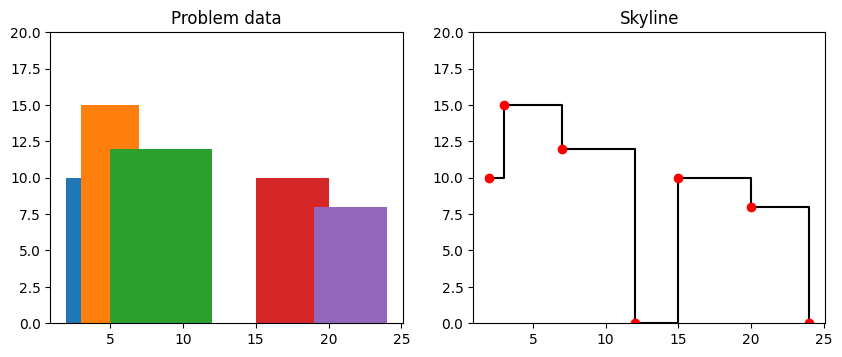

In [176]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure and a set of subplots with equal width
fig, axs = plt.subplots(1, 2, figsize=(10,5), gridspec_kw={'width_ratios': [1, 1]})

# Create the first subplot to show the problem data as colored filled rectangles
for building in example_buildings:
 left, right, height = building
 axs[0].fill([left, right, right, left], [0, 0, height, height])

axs[0].set_ylim([0, 20])
axs[0].set_aspect('equal')
axs[0].set_title('Problem data')

# Create the second subplot to plot the skyline as a staircase function
x = [x for x, _ in example_skyline]
y = [y for _, y in example_skyline]
axs[1].step(x, y, where='post', color='black')

# Add the solution points as red dots
axs[1].plot(x, y, 'ro')

axs[1].set_ylim([0, 20])
axs[1].set_aspect('equal')
axs[1].set_title('Skyline')

plt.show()


## Algorithmes à implanter

On vous demande de résoudre ce problème de 3 façons différentes :

1. En utilisant un algorithme force brute simple ;
2. En utilisant un algorithme diviser pour régner ;
3. En utilisant un algorithme diviser pour régner avec seuil de récursivité non élémentaire.

Pour l’algorithme 3, vous devrez déterminer un seuil de récursivité expérimentalement. Les exemplaires dont la taille est en deçà de ce seuil ne sont plus résolus récursivement mais plutôt directement avec l’algorithme 1.

Vos algorithmes doivent donner des réponses où les couples `(x, h)` sont triés de façon non décroissante selon x (cf. exemple plus haut). Par ailleurs, ils ne doivent pas donner de solutions avec couples redondants, i.e. deux couples qui se suivent ne peuvent pas avoir la même hauteur ni la même abscisse.


## Jeu de données

La fonction `generate_sample` ci-dessous permet de générer un exemplaire d'une taille donnée.

La fonction `get_dataset` permet de récupérer un dataset pour la liste de taille fournie. Elle prend également en entrée un graine aléatoire pour générer le dataset en question.

Afin que chaque groupe travaille avec un set différent, mais que vos propres expériences soient reproductibles, entrez l'un de vous matricule comme graine aléatoire dans la cellule ci-dessous.

Vous êtes bien entendu libres de tester et mesurer vos algorithme sur le même dataset qu'un autre groupe. Pour cela, générez simplement un dataset avec la même graine et la même liste de taille.



In [177]:
import random

max_width = 50
max_dist = 30
max_height = 300

def generate_sample(size):
    sample = []
    last_l = 0
    for _ in range(size):
        l = random.randint(last_l, last_l + max_dist)
        r = random.randint(l+1, l + max_width)
        h = random.randint(1, max_height)
        sample.append((l, r, h))
        last_l = l
    return sample

def get_dataset(seed, sizes):
    random.seed(seed)
    return { size: [generate_sample(size) for _ in range(5)]
        for size in sizes }

In [178]:
# TODO: Utilisez un de vos matricules comme graine et une liste de tailles judicieusement choisies
dataset = get_dataset(2179304, [100*i for i in range(1, 101)])


# Implantations et expérimentations

Ces fonctions auxiliaires vous sont fournies pour vérifier l'exactitude des vos algorithmes, mesurer leurs performance et afficher vos résultats.

Il est recommandé de prendre le temps de lire et comprendre le code.

Exécutez la cellule ci-dessous pour pouvoir utiliser les fonctions auxiliaires.

In [179]:
import matplotlib.pyplot as plt
import time
import statistics as stats

def verification_plot(buildings, skyline):
    # Create a figure and a set of subplots with equal width
    fig, ax = plt.subplots(figsize=(10,5))

    # Create the first subplot to show the problem data as colored filled rectangles
    for building in buildings:
        left, right, height = building
        ax.fill([left, right, right, left], [0, 0, height, height])

    # Create the second subplot to plot the skyline as a staircase function
    x = [x for x, _ in skyline]
    y = [y for _, y in skyline]
    ax.step(x, y, where='post', color='black')

    # Add the solution points as red dots
    ax.plot(x, y, 'ro')

    plt.show()


def measure(procedure, sample):
    """ Mesure le temps d'execution d'une procédure sur un unique exemplaire """
    start = time.time()
    solution = procedure(sample)
    end = time.time()
    sorting_time = end - start
    return solution, sorting_time


def measure_mean_time(procedure, samples):
    """ Mesure le temps moyen d'execution d'une procédure sur une liste d'exemplaires """
    total_time = 0
    for sample in samples:
        solution, compute_time = measure(procedure, sample)
        total_time += compute_time
    return total_time / len(samples)


def measure_procedure(procedure, dataset):
    """ Mesure les temps moyens d'execution d'une procédure sur chaque point d'un dataset """
    return {size: measure_mean_time(procedure, samples) for size, samples in dataset.items()}

def display_measures_table(measures):
    print("{: <12} {: <12}".format("Taille", "Temps moyen (s)"))
    for size, measure in measures.items():
        print("{: <12} {: <12}".format(size, measure))


def display_test_puissance(vals, title="Test de puissance"):
    x = list(vals.keys())
    y = list(vals.values())

    # Perform linear regression
    m, b = stats.linear_regression(x, y)

    r = list(map(lambda x : m*x + b, x))

    # Create the line equation
    line_eq = f"y = {m:.2f}x + {b:.2f}"

    # Plot the points
    plt.scatter(x, y, label='Mesures')

    # Plot the regression line
    plt.plot(x, r, color="red", label='Regression linéaire')

    # Add labels and title
    plt.xlabel('log Taille')
    plt.ylabel('log Temps')
    plt.title(title)

    # Add legend
    plt.legend(bbox_to_anchor=(0.60, 0), loc='lower left')

    # Display the line equation
    plt.text(min(x), max(y), line_eq)

    # Show the plot
    plt.show()

def display_test_rapport(vals, title="Test du rapport"):
    x = list(vals.keys())
    y = list(vals.values())

    plt.plot(x, y, label='Mesures')
    plt.scatter(x, y, label='Mesures')

    # Add labels and title
    plt.xlabel('Taille')
    plt.ylabel('Temps / f(taille)')
    plt.title(title)
    plt.show()


def display_test_constantes(vals, title="Test des constantes"):
    x = list(vals.keys())
    y = list(vals.values())

    # Perform linear regression
    m, b = stats.linear_regression(x, y)

    r = list(map(lambda x : m*x + b, x))

    # Create the line equation
    line_eq = f"y = {m:.2E}x + {b:.2E}"

    # Plot the points
    plt.scatter(x, y, label='Mesures')

    # Plot the regression line
    plt.plot(x, r, color="red", label='Regression linéaire')

    # Add labels and title
    plt.xlabel('f(Taille)')
    plt.ylabel('Temps')
    plt.title(title)

    # Add legend
    plt.legend(bbox_to_anchor=(0.60, 0), loc='lower left')

    # Display the line equation
    plt.text(min(x), max(y), line_eq)

    # Show the plot
    plt.show()


def display_mesures_seuil(vals):
    x = list(vals.keys())
    y = list(vals.values())
    plt.plot(x, y, label='Mesures')
    plt.scatter(x, y, label='Mesures')

    # Add labels and title
    plt.xlabel('Seuil')
    plt.ylabel('Temps')
    plt.title('Selection du seuil')
    plt.show()




## Algorithme naïf (brute force) (6 points)

### Implémentation (1.5 points)

TODO: Implantez un algorithme naïf pour le problème de la ligne d'horizon.

TODO: Utilisez la fonction `verification_plot` sur l'exemplaire de présentation du problème `example_buildings` pour vérifier l'exactitude de votre algorithme et laissez la figure dans votre rapport.

[(2, 10), (3, 15), (7, 12), (12, 0), (15, 10), (20, 8), (24, 0)]


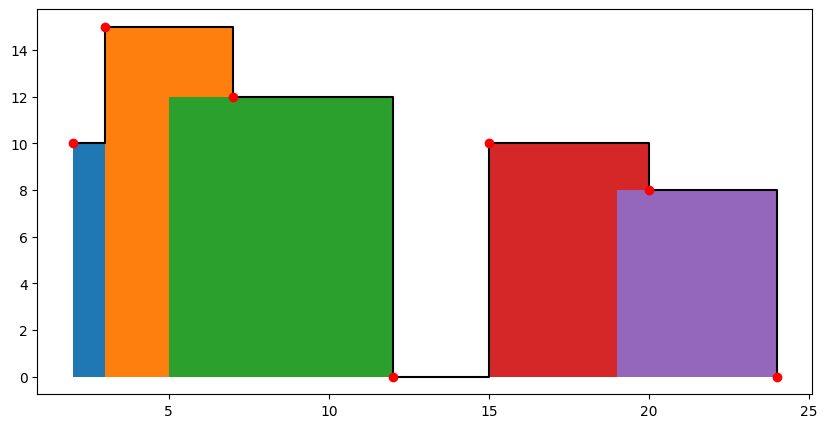

In [180]:
import math
import heapq

def skyline_bruteforce(buildings):
    skyline = []
    # TODO : Implantez un algorithme naïf
    height_intervals = [] # [(height, start, end)]

    for left, right, height in buildings:
        height_intervals.append((height, left, right)) # top segment of the building
        height_intervals.append((0, right, right)) #  bottom right corner of the building

    height_intervals.sort(key=lambda x: (x[1], -x[0]))

    current_height_intervals = [(0, math.inf)] # [(height, end)]

    for (height, start, end) in height_intervals:
        heapq.heappush(current_height_intervals, (-height, end)) # negative height because it's a max heap

        while current_height_intervals[0][1] <= start: # discard intervals that don't overlap with the current one
            heapq.heappop(current_height_intervals)
        
        current_max_height = -current_height_intervals[0][0]

        if len(skyline) == 0 or current_max_height != skyline[-1][1]: # if the height has changed, add a new point
            skyline.append((start, current_max_height))
        
    return skyline

test_buildings = example_buildings
# test_buildings = generate_sample(5) # random
# test_buildings = [(2, 39, 177), (21, 30, 54)] # edge cas 1
# test_buildings = [(7, 8, 199), (7, 43, 282)] # edge cas 2
# test_buildings =  [(7, 8, 199), (7, 43, 100)] # edge cas 3
# test_buildings = [(11, 47, 87), (22, 28, 244), (47, 80, 202)] # edge cas 4
# test_buildings = [(5, 51, 224), (30, 75, 77), (34, 35, 264)] # edge cas 5
# test_buildings = [(19, 21, 200), (40, 83, 186), (40, 73, 149)] # edge cas 6
# test_buildings = [(7, 48, 194), (32, 72, 45), (48, 72, 124)] # edge cas 7
# test_buildings = [(7, 21, 270), (26, 49, 292), (35, 67, 300), (61, 84, 254), (63, 84, 39)] # edge cas 8
# test_buildings = [(19, 66, 194), (29, 60, 97), (29, 71, 192), (51, 91, 243), (80, 91, 73)] # edge cas 9

result = skyline_bruteforce(test_buildings)
print(result)
verification_plot(test_buildings, result)

### Analyse asymptotique (1 points)

TODO: Quelle est la complexité asymptotique théorique de cet algorithme?

>Soit $n$, la taille d'un exemplaire (qui représente le nombre de buildings dans notre problème).<br>
Analysons étape par étape l'algorithme : <br>
> 1. On construit la liste d'intervalles d'hauteur : Cette opération est en $\Theta(n)$ vu qu'on parcourt tous les buildings.
> 2. Puis on trie ces intervalles avec la méthode sort() : Les opérations de trie se font en $\Theta(nlgn)$
> 3. Puis on itère sur tous les buildings pour construire le skyline. Cette opération est en  $\Theta(nlgn)$, car il y a 2n itérations et chaque heapq.heappush() est en  $\Theta(lgn)$. On pourrait penser que la complexité est en $\Theta(n^2)$, puisqu’une boucle `while` est imbriquée dans une boucle `for`. Cependant, en regardant de plus près, on constate que la boucle `while` ne fait que retirer des éléments de la file de priorité. Elle ne peut donc pas en retirer plus que la boucle `for` n’en ajoute. Or, la boucle `for` ajoute au total (2n) éléments, ce qui implique que `heapq.heappop()` ne peut pas être exécuté plus de (2n) fois. Si l’on répartit ces (2n) `heapq.heappop()` sur les (2n) itérations de la boucle `for`, la boucle `while` a un coût amorti de $\Theta(1)$.

>En additionnant les différentes parties de l'algorithme de force brute, nous obtenons $\Theta(n+nlgn+nlgn)$.<br>
En utlisant, la règle du maximum vu en classe qui stipule que $\Theta(f+g)=\theta(max(f,g))$, on peut conclure que le temps d'exécution de notre algo brute $T(n)\in\Theta(nlgn)$.  

### Mesures (0.5 points)

In [181]:
measures_bruteforce = measure_procedure(skyline_bruteforce, dataset)

Représentez vos mesures sous forme d'un tableau avec la fonction `display_measures_table`.

In [182]:
display_measures_table(measures_bruteforce)

Taille       Temps moyen (s)
100          0.00019898414611816407
200          0.00030517578125
300          0.00040445327758789065
400          0.00047173500061035154
500          0.0006216049194335937
600          0.0009273052215576172
700          0.0010640144348144532
800          0.0009421348571777344
900          0.0011139392852783203
1000         0.001215076446533203
1100         0.001395273208618164
1200         0.001569366455078125
1300         0.0015695571899414062
1400         0.0017040252685546875
1500         0.001867961883544922
1600         0.0023181915283203127
1700         0.0022266864776611327
1800         0.002353668212890625
1900         0.0024930953979492186
2000         0.0026372432708740234
2100         0.0034018516540527343
2200         0.003284168243408203
2300         0.0032015323638916017
2400         0.003117227554321289
2500         0.0033072471618652345
2600         0.0035526275634765623
2700         0.0037059783935546875
2800         0.003797292709350586
2

### Analyse hybride

#### Test de puissance (1 point)

Effectuez le test de puissance de votre algorithme.

Pour cela complétez d'abord le code de la fonction `values_test_puissance` pour obtenir les valeurs à placer sur le graphe. Utilisez ensuite la fonction `display_test_puissance` pour afficher le graphe.

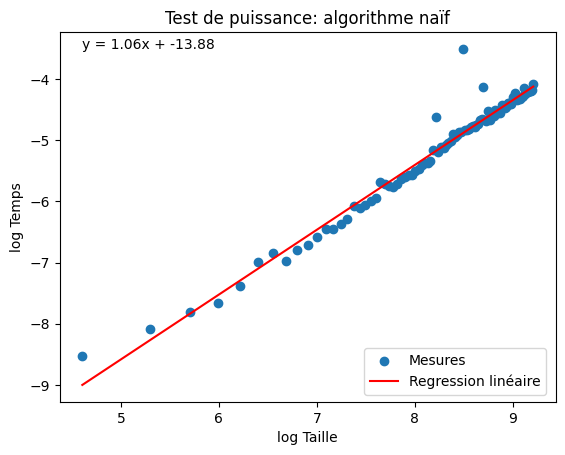

In [183]:
def values_test_puissance(measures):
    return {
        # TODO: calculez les valeurs pour le test de puissance
        math.log(size): math.log(measure)
        for size, measure in measures.items()
    }

display_test_puissance(values_test_puissance(measures_bruteforce), "Test de puissance: algorithme naïf")

TODO: Analysez le graphe obtenu pour le test de puissance.

> Selon les notes de cours, le test de puissance nous donne une idée générale du taux de croissance de notre algorithme.<br>
Le test est effectué en plaçant les coupes (x, y) sur une échelle log-log, où x représente la taille de l'exemplaire et y représente la consommation de ressources (temps). <br>
On observe que les points (mesures) s'alignent presque sur la droite de régression (en rouge).<br>
La pente de la droite est de 1.06 (ce qui est entre 1 et 2). Donc, cela nous indique que le taux de croissance de l'algorithme naïf est entre $O(n)$ et $O(n^2)$.<br>
Cela appuie notre hypothèse (analyse asymptotique) effectuée précédement où $T(n)\in\Theta(nlgn)$.

#### Test du rapport (1 point)

Effectuez le test du rapport avec une ou plusieurs fonctions f pertinentes.

Complétez d'abord la fonction `values_test_rapport` permettant d'obtenir les valeurs à reporter sur le graphe. Puis utilisez la fonction `display_test_rapport` pour afficher le graphe.

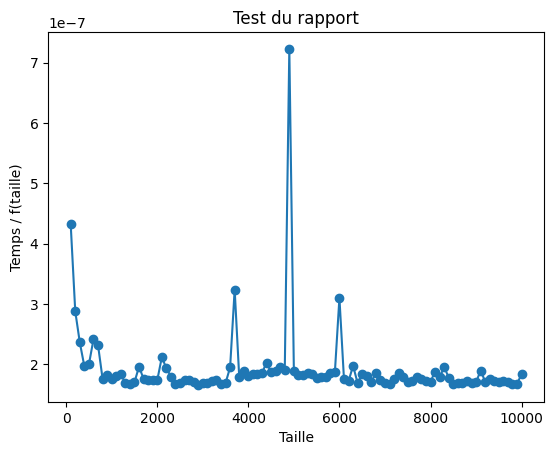

In [184]:
def values_test_rapport(measures, f):
    return {
        size: measure / f(size)
        for size, measure in measures.items()
    }

# TODO: definissez f judicieusement
def f(x):
    return x*math.log(x)

display_test_rapport(values_test_rapport(measures_bruteforce, f))

TODO: Analysez le graphe obtenu pour le test du rapport. Précisez le critère de choix de votre ou vos fonctions.

> **Critère de choix pour la fonction** : Selon les notes de cours, le test du rapport du permet de valider si le taux de croissance croit selon une fonction $f(x)$. Durant l'analyse asymptotique nous avons déterminé que le temps d'exécution de l'algorithme naïf $T(n)\in\Theta(nlgn)$. C'est l'hypothèse que nous souhaitons vérifier avec le test du rapport, pour cette raison, nous posons $f(x)=xlgx$<br><br>
> **Analyse du graphe** : Nous observons que les points du graphe convergent vers une valeur constante (>0) au fur et à mesure que la taille de l'exemplaire augmente. On constate aussi que la courbe lorsque n tend vers l'infini tend plutôt vers une valeur constante.<br><br>
> **Conclusion** : Comme nous avons une convergence, cela signifie que notre hypothèse est juste. Le temps d'exécution de l'algo croît selon l'ordre exact de $\Theta(nlgn)$.


### Test des constantes (1 point)

Effectuez le test des constantes avec une ou plusieurs fonctions f pertinentes.

Complétez d'abord la fonction `values_test_constantes` permettant d'obtenir les valeurs à reporter sur le graphe. Puis utilisez la fonction `display_test_constantes` pour afficher le graphe.

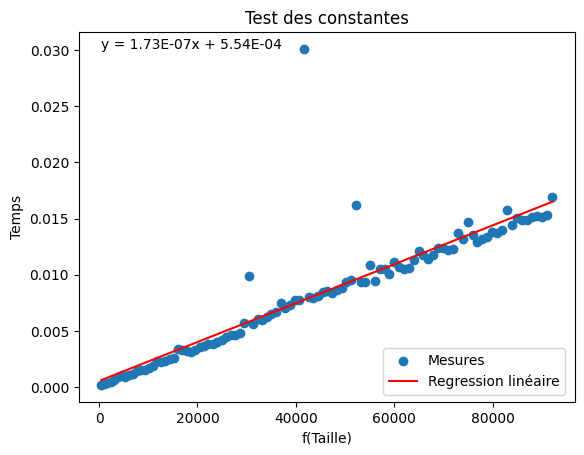

In [185]:
def values_test_constantes(measures, f):
    return {
        # TODO: calculez les valeurs pour le test du rapport
        f(size): measure
        for size, measure in measures.items()
    }

# TODO: définissez f judicieusement
def f(x):
    return x*math.log(x)

display_test_constantes(values_test_constantes(measures_bruteforce, f))

TODO: Indiquez les valeurs des constantes mises en évidence par le test.

> Le but de ce test est venir préciser notre hypothèse en venant préciser les constantes qui sont en jeu.<br>
Notre hypothèse est que le temps d'exécution de l'algo brute $T(n)\in\Theta(nlgn)$. Nous posons la fonction $f(x)=xlgx$.<br><br>
**Observations du graphe** : La majorité des points s'alignent avec la droite de régression.<br><br>
**Interprétation et constantes mises en évidence par le test** : Selon les notes de cours, si on peut faire passer une droite à travers notre nuages de points (ce qui est notre cas), alors :
> - La pente de la droite représente la valeur moyenne de la constante multiplicative pour des échantillons qui tendent vers infini. Cette constante multiplicative est de $1,73\cdot10^{-7}$.<br>
> - L'ordonnée à l'origine correspond au coût fixe. Ce coût est de $5,54\cdot10^{-4}$ dans notre cas.


## Algorithme diviser pour régner (6 points)


### Implémentation (1.5 points)

TODO: Implantez un algorithme pour le problème de la ligne d'horizon utlisant le patron de conception "Diviser pour régner".

Il est conseillé de prévoir un paramètre pour le seuil de récursivité (e.g. `threshold`), en dessous duquel, vous utiliserez l'algorithme naïf écrit précédemment. Dans ce cas, le seuil devrait être 1.

In [186]:
def skyline_divide_and_conquer(buildings, threshold):
    # TODO: Implantez un algorithme diviser-pour-régner
    if len(buildings) <= threshold:
        return skyline_bruteforce(buildings)
    
    mid = len(buildings) // 2
    left_buildings = buildings[:mid]
    right_buildings = buildings[mid:]
    
    left_skyline = skyline_divide_and_conquer(left_buildings, threshold)
    right_skyline = skyline_divide_and_conquer(right_buildings, threshold)
    
    skyline = []
    i = j = 0

    while i < len(left_skyline) and j < len(right_skyline):
        x_left = left_skyline[i][0]
        x_right = right_skyline[j][0]
        current_position = min(x_left, x_right)
        
        if x_left <= x_right:
            i += 1
        if x_right <= x_left:
            j += 1            
        
        current_max_height = max(left_skyline[i-1][1], right_skyline[j-1][1])

        if len(skyline) == 0 or current_max_height != skyline[-1][1]:
            skyline.append((current_position, current_max_height))

    return skyline + left_skyline[i:] + right_skyline[j:]


TODO: Utilisez la fonction `verification_plot` sur l'exemplaire de présentation du problème `example_buildings` pour vérifier l'exactitude de votre algorithme et laissez la figure dans votre rapport.

[(2, 10), (3, 15), (7, 12), (12, 0), (15, 10), (20, 8), (24, 0)]


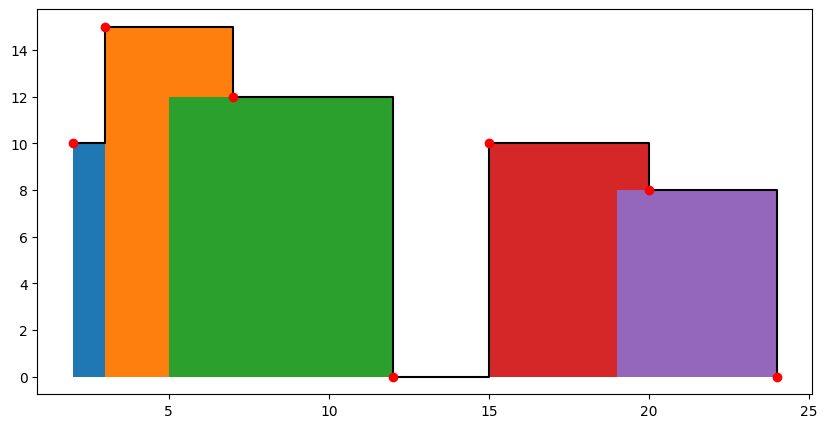

In [187]:
def skyline_divide_and_conquer_naive_threshold(buildings):
    # TODO diviser pour régner avec un seuil de récursivité de 1
    return skyline_divide_and_conquer(buildings, threshold=1)

test_buildings = example_buildings
# test_buildings = generate_sample(5) # random
# test_buildings = [(2, 39, 177), (21, 30, 54)] # edge case 1
# test_buildings = [(7, 8, 199), (7, 43, 282)] # edge case 2
# test_buildings =  [(7, 8, 199), (7, 43, 100)] # edge case 3
# test_buildings = [(11, 47, 87), (22, 28, 244), (47, 80, 202)] # edge case 4
# test_buildings = [(5, 51, 224), (30, 75, 77), (34, 35, 264)] # edge case 5
# test_buildings = [(19, 21, 200), (40, 83, 186), (40, 73, 149)] # edge case 6
# test_buildings = [(7, 48, 194), (32, 72, 45), (48, 72, 124)] # edge case 7
# test_buildings = [(7, 21, 270), (26, 49, 292), (35, 67, 300), (61, 84, 254), (63, 84, 39)] # edge case 8
# test_buildings = [(19, 66, 194), (29, 60, 97), (29, 71, 192), (51, 91, 243), (80, 91, 73)] # edge case 9

result = skyline_divide_and_conquer_naive_threshold(test_buildings)
print(result)
verification_plot(test_buildings, result)

### Analyse asymptotique (1 points)

TODO: Quelle est la complexité asymptotique théorique de cet algorithme?

Soit $n$, le nombre d'éléments dans un exemplaire.<br>
Dans cette partie, nous utilisons notre algorithme naïf pour résoudre les sous-ensembles dont la taille est inférieure ou égale à notre seuil de récursivité (threshold).<br>
Comme ce dernier est une constante (ne varie pas selon $n$), on est en $\Theta(1)$.
```python
if len(buildings) <= threshold:
    return skyline_bruteforce(buildings)
```
Pour l'étape de décomposition, la liste de buildings est séparée en deux parties ($n/2$) qu'on recopie dans deux listes distinctes. On remarque qu'il s'agit d'une décomposition parfaitement équilibrée, ce qui est privilégié pour un algorithme de type diviser pour régner (car possible dégradation de l'algorithme pour une décomposition déséquilibrée). L'opération de copie se fait en $\Theta(n)$, puisqu'on doit parcourir tous les éléments (pas plus, pas moins) pour les recopier.<br>
On fait ensuite 2 appels récursifs. Puis, on recombine les sous-solutions. Comme chaque élément est traitée, cette étape de recombinaison se fait en $\Theta(n)$.
Nous allons utiliser le Master Theorem pour calculer la complexité asymptotique de la récusion.<br>
La formule est générale est la suivante (selon les notes de cours) :<br>
$$T(n)=l \cdot T(n/b)+cn^k$$
où $l \ge 1$, $b > 1$, $k \ge 0$ et $c > 0$ sont des constantes.<br><br>
On a 2 appels récursifs :
$$T(n)=T(⌊n/2⌋)+T(⌈n/2⌉)+g(n)$$
où $g(n) \in \Theta(n)$ représente la quantité de travail pour la recombinaison.<br><br>
Comme le plancher et le plafond sont sans impact, on peut réécrire la formule de la manière suivante : 
$$T(n)=2T(n/2)+g(n)$$
$l = 2$, $b = 2$, $k = 1$. Cela nous donne un $b^k=2^1=2$. Et donc, nous sommes dans le cas 2 où $l=b^k$.<br>
$$T(n) \in \Theta(nlg n)$$
<br> Ainsi, la résolution d'un sous-ensemble se fait en $\Theta(1)$, la décomposition en $\Theta(n)$ et la partie appels récursifs et recombinaison en $\Theta(n lg n)$, ce qui donne : 
$$\Theta(n lg n + n + 1)$$
La règle du maximum vue en classe selon laquelle : $\Theta(f+g) = \Theta(max(f,g))$ peut s'appliquer.<br>
Et on obtient une complexité asymptotique finale de :
$$T(n) \in \Theta(n lg n)$$

### Mesures (0.5 points)

In [188]:
measures_divide_naive_threshold = measure_procedure(skyline_divide_and_conquer_naive_threshold, dataset)

In [189]:
display_measures_table(measures_divide_naive_threshold)

Taille       Temps moyen (s)
100          0.0005137443542480469
200          0.0007915973663330078
300          0.0015001773834228515
400          0.0018423080444335937
500          0.002348804473876953
600          0.003229713439941406
700          0.0050868988037109375
800          0.003557920455932617
900          0.003912019729614258
1000         0.004778718948364258
1100         0.00523991584777832
1200         0.005168485641479492
1300         0.00595250129699707
1400         0.0063304901123046875
1500         0.006608390808105468
1600         0.007325458526611328
1700         0.007868671417236328
1800         0.008628225326538086
1900         0.008464527130126954
2000         0.008310174942016602
2100         0.008935546875
2200         0.009932136535644532
2300         0.010279226303100585
2400         0.010936450958251954
2500         0.010620355606079102
2600         0.01104440689086914
2700         0.011835527420043946
2800         0.012508535385131836
2900         0.0128858

### Analyse hybride

#### Test de puissance (1 point)

Effectuez le test de puissance de votre algorithme.

Utilisez la fonction `display_test_puissance` pour afficher le graphe.

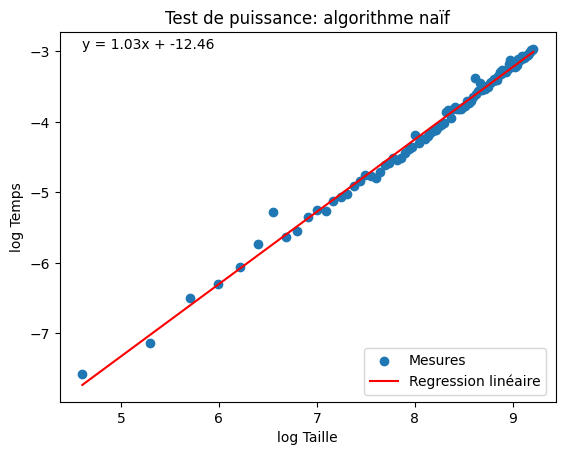

In [190]:
display_test_puissance(values_test_puissance(measures_divide_naive_threshold), "Test de puissance: algorithme naïf")

TODO: Analysez le graphe obtenu pour le test de puissance.

On observe que les points (mesures) s'alignent presque sur la droite de régression (en rouge).<br>
La pente de la droite est de 1.03 (ce qui est entre 1 et 2). Donc, cela nous indique que le taux de croissance de l'algorithme est entre $O(n)$ et $O(n^2)$.<br>
Cela appuie notre hypothèse (analyse asymptotique) effectuée précédement où $T(n)\in\Theta(nlgn)$.

#### Test du rapport (1 point)

Effectuez le test du rapport avec une ou plusieurs fonctions f pertinentes.

Utilisez la fonction `display_test_rapport` pour afficher le graphe.

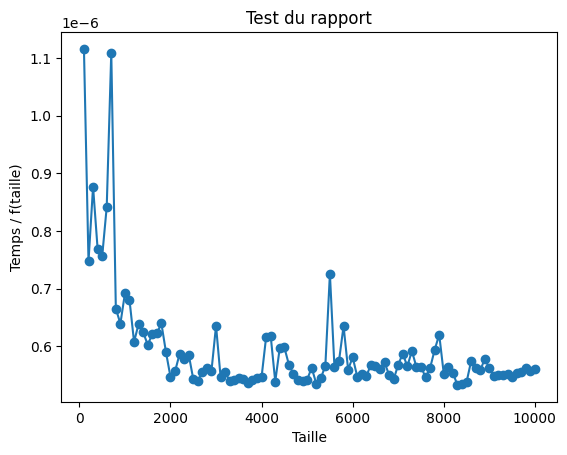

In [191]:
# TODO: définissez f judicieusement
def f(x):
    return x*math.log(x)

display_test_rapport(values_test_rapport(measures_divide_naive_threshold, f))

TODO: Analysez le graphe obtenu pour le test du rapport.

> Durant l'analyse asymptotique, nous avons déterminé que le temps d'exécution de l'algorithme diviser-pour-regner avec seuil de récursivité de 1 est de $T(n)\in\Theta(nlgn)$. C'est cette hypothèse que nous tentons de vérifier avec le test du rapport en posant $f(x)=xlgx$<br><br>
> **Analyse du graphe** : Un peu à l'instar de l'algorithme de force brute, nous observons que les points du graphe convergent vers une valeur constante (>0) au fur et à mesure que la taille de l'exemplaire augmente. On constate aussi que la courbe lorsque n tend vers l'infini tend plutôt vers une valeur constante.<br><br>
> **Conclusion** : Comme nous avons une convergence vers une constante positive et différente de 0, cela signifie que notre hypothèse est juste. Le temps d'exécution de l'algo croît selon l'ordre exact de $\Theta(nlgn)$.

### Test des constantes (1 point)

Effectuez le test des constantes avec une ou plusieurs fonctions f pertinentes.

Utilisez la fonction `display_test_constantes` pour afficher le graphe.

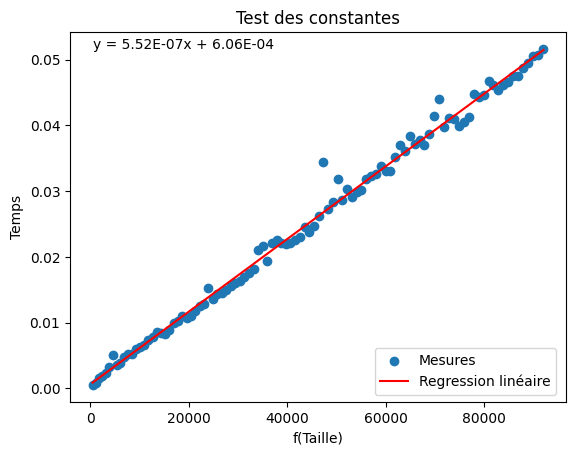

In [192]:
# TODO: définissez f judicieusement
def f(x):
    return x*math.log(x)

display_test_constantes(values_test_constantes(measures_divide_naive_threshold, f))

TODO: Indiquez les valeurs des constantes mises en évidence par le test.

> Pour commencer, notre hypothèse est que le temps d'exécution de l'algo diviser-pour-regner naïf est $T(n)\in\Theta(nlgn)$. Nous posons la fonction $f(x)=xlgx$.<br><br>
**Observations du graphe** : on observe que la plupart semblent alignés avec la droite de régression.<br><br>
**Interprétation et constantes mises en évidence par le test** : Comme on peut faire passer une droite à travers le nuages de points, nous pouvons affirmer que :
> - La pente de la droite représente la valeur moyenne de la constante multiplicative pour des échantillons qui tendent vers infini. Cette constante multiplicative est de $5,52\cdot10^{-7}$.<br>
> - L'ordonnée à l'origine correspond au coût fixe. Ce coût est de $6,06\cdot10^{-4}$.

## Algorithme diviser pour régner (seuil choisi) (6 points)

### Sélection du seuil (1.5 points)

Effectuez les mesures avec plusieurs seuils de récursivité pour déterminer le seuil le plus judicieux.

In [219]:
measures_threshold = {
    i:
    measure_mean_time(
        lambda sample: skyline_divide_and_conquer(sample, i),
        dataset[100*100]) # TODO: sélectionnez un exemplaire
        for i in range(1, 101) # TODO: testez une liste judicieuse de seuils
}

n = min(measures_threshold, key=measures_threshold.get)
print(f"Le seuil le plus judicieux est {n}.")

Le seuil le plus judicieux est 82.


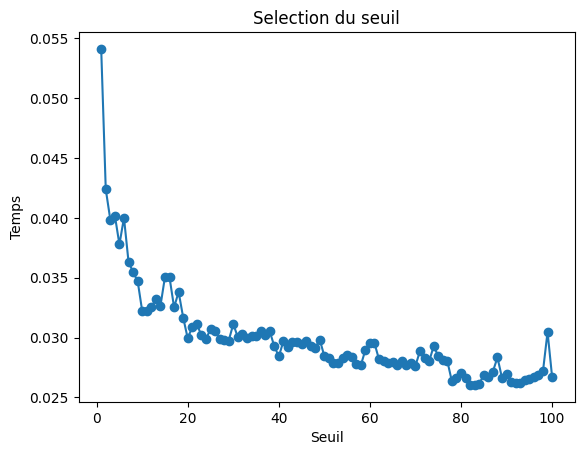

In [220]:

display_mesures_seuil(measures_threshold)


TODO: Quel est le seuil de récursivité de le plus judicieux ? Sur quel critère l'avez vous sélectionné ?

> Nous avons vu en classe deux méthodes pour trouver le seuil de récursivité ($n_{min}$).<br>
> - La première est la **méthode hybride**. <br>
On évalue empiriquement la valeur des constantes (en laboratoire). Puis, on cherche un seuil pour lequel le temps d'exécution de l'algo naïf et celui l'algo de récursion sont semblables. On résoud l'égalité pour trouver $n_{min}$.<br>
> - La deuxième est la **méthode essai-erreur**. Comme son nom l'indique, on essaie plusieurs valeurs de seuil et on sélectionne celui qui donnera un meilleur résultat que ses voisins. Par contre, il est possible qu'il ne s'agit pas du seuil optimal, puisque ce qu'on trouve est plutôt un minimum local.<br><br>

> En raison de sa simplicité d'application, nous avons choisi d'utiliser la méthode essai-erreur. Nous avons choisi un exemplaire de taille $n=10000$.
> Le seuil de récursivité le plus judicieux est un seuil qui va minimiser le temps d'exécution moyen de l'algorithme diviser pour régner. Selon le graphique, ce seuil est de 82.

TODO: Utilisez votre fonction générique pour implanter un algorithme avec le seuil choisi.

TODO: Utilisez la fonction `verification_plot` sur l'exemplaire de présentation du problème `example_buildings` pour vérifier l'exactitude de votre algorithme et laissez la figure dans votre rapport.

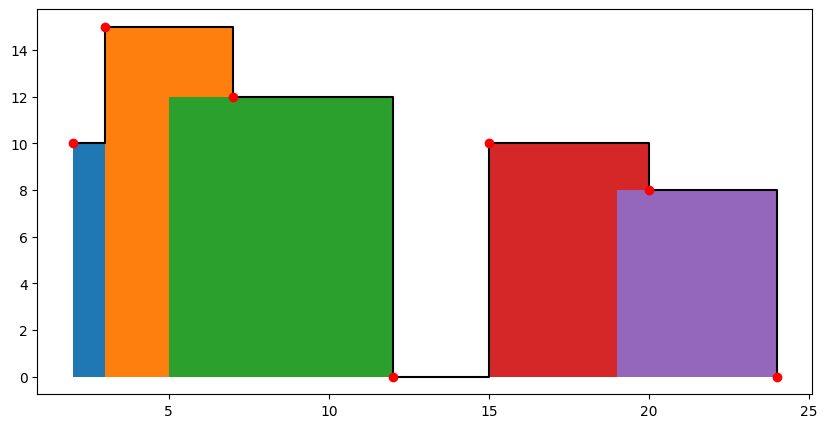

In [221]:
def skyline_divide_and_conquer_best_threshold(buildings):
    # TODO diviser pour régner avec un seuil de récursivité de n
    return skyline_divide_and_conquer(buildings, threshold=n)

verification_plot(example_buildings, skyline_divide_and_conquer_naive_threshold(example_buildings))

### Analyse asymptotique (1 points)

TODO: Quelle est la complexité asymptotique théorique de cet algorithme?

> En théorie, le seuil de récursivité ne change pas la complexité asymptotique théorique de notre algorithme.<br>
Donc, la complexité reste inchangée : $T(n)\in\Theta(nlgn)$.<br>
Par contre, comme nous l'avons mesuré précédemment, le choix d'un bon seuil peut, dans la pratique, accélérer le temps d'exécution de l'algorithme.

### Mesures (0.5 points)

In [235]:
measures_divide_best_threshold = measure_procedure(skyline_divide_and_conquer_best_threshold, dataset)

In [241]:
display_measures_table(measures_divide_best_threshold)

Taille       Temps moyen (s)
100          0.00029954910278320315
200          0.0005278587341308594
300          0.0008168697357177734
400          0.0011202335357666016
500          0.0015880584716796875
600          0.0014598846435546875
700          0.001771259307861328
800          0.0014633655548095704
900          0.0020069122314453126
1000         0.0022578716278076174
1100         0.0023297786712646483
1200         0.0023869991302490233
1300         0.002557039260864258
1400         0.0033884048461914062
1500         0.0032434940338134767
1600         0.0032473087310791017
1700         0.0038419246673583986
1800         0.0038688182830810547
1900         0.004166269302368164
2000         0.0042095184326171875
2100         0.004452848434448242
2200         0.0049931049346923825
2300         0.005098962783813476
2400         0.005263376235961914
2500         0.0052835941314697266
2600         0.005907011032104492
2700         0.00635986328125
2800         0.006670236587524414
290

### Analyse hybride

#### Test de puissance (1 point)

Effectuez le test de puissance de votre algorithme.

Utilisez la fonction `display_test_puissance` pour afficher le graphe.

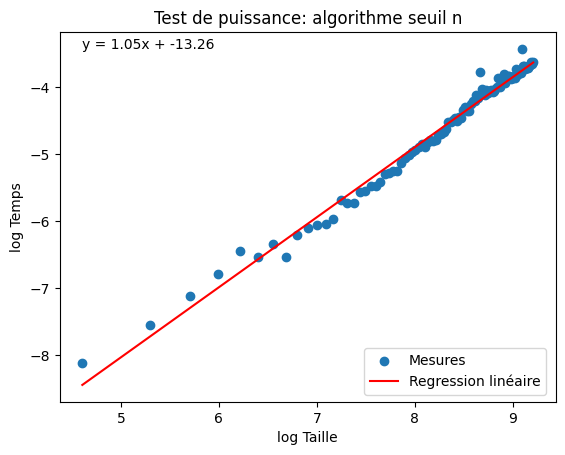

In [237]:
display_test_puissance(values_test_puissance(measures_divide_best_threshold), "Test de puissance: algorithme seuil n")

Analysez le graphe obtenu pour le test de puissance.

> On observe que les points s’alignent approximativement sur une droite de pente m = 1,05. Nous faisons l’hypothèse que la complexité de l’algorithme est $\Theta(nlgn)$. Dans ce cas, la pente attendue devrait se situer entre m = 1 (correspondant à $\Theta(n)$) et m = 2 (correspondant à $\Theta(n^2)$). Or, comme 1 < 1,05 < 2, cette observation appuie notre hypothèse pour l’instant.

#### Test du rapport (1 point)

Effectuez le test du rapport avec une ou plusieurs fonctions f pertinentes.

Utilisez la fonction `display_test_rapport` pour afficher le graphe.

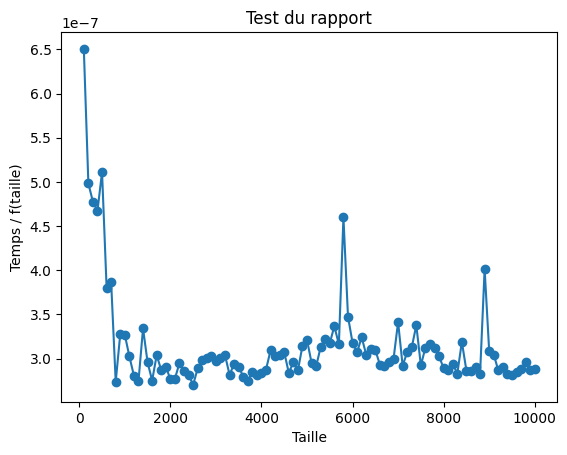

In [238]:
# TODO: définissez f judicieusement
def f(x):
    return x * math.log(x)

display_test_rapport(values_test_rapport(measures_divide_best_threshold, f))

TODO: Analysez le graphe obtenu pour le test du rapport.

> On observe que les valeurs se stabilisent autour de 3.0. Notre estimation de la complexité était $\Theta(nlgn)$. Si cette estimation était trop faible, les valeurs continueraient à croître avec la taille. Si elle était trop élevée, elles tendraient vers zéro. Or, ce n’est pas le cas : on observe plutôt une convergence. Ainsi, notre estimation de complexité semble correcte pour l’instant.

### Test des constantes (1 point)

Effectuez le test des constantes avec une ou plusieurs fonctions f pertinentes.

Utilisez la fonction `display_test_constantes` pour afficher le graphe.

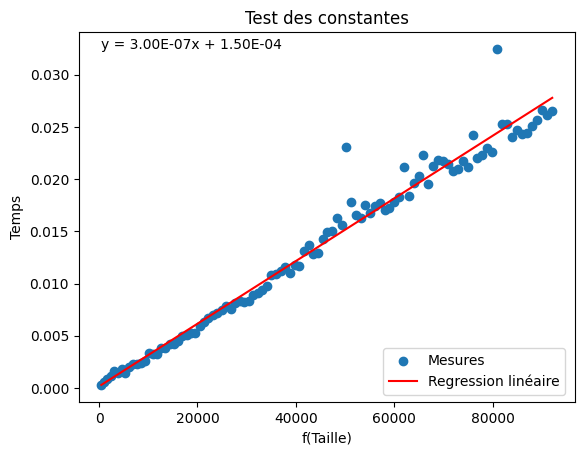

In [239]:
# TODO: définissez f judicieusement
def f(x):
    return x * math.log(x)

display_test_constantes(values_test_constantes(measures_divide_best_threshold, f))


TODO: Indiquez les valeurs des constantes mises en évidence par le test.

> On observe que les points s'alignent approximativement sur une droite de pente c = 3.00E-07 et une ordonnée à l'origine de b = 1.50E-04. Cela confirme à nouveau la validité  de notre hypothèse.

# Conclusion (2 points)


TODO: Commentez l'impact du seuil de récursivité. Que représente t'il pour l'algorithme diviser pour régner et l'algorithme naïf ?

TODO: En vous basant sur vos résultats, résumez vos découvertes et analyses, et indiquez dans quelles circonstances vous utiliserez chacun de ces 3 algorithmes en démontrant leurs points forts et point faibles.

> Bien que les résultats montrent que le seuil de récursivité n'a pas changé la complexité asymptotique de notre algorithme diviser pour régner, on observe toutefois une meilleure performance non négligeable au niveau du temps d'exécution. Le temps d'exécution avec le seuil naive (n = 1) était de 25 sec, alors qu'il est passé à 15 sec avec le nouveau seuil (n = 343).

> En résumé, les résultats montrent que les trois algorithmes présentent une complexité asymptotique en $\Theta(nlgn)$. Toutefois, leurs temps d’exécution diffèrent sensiblement : l’algorithme par force brute est le plus rapide, suivi de l’algorithme de type diviser pour régner avec un seuil de récursion calibré expérimentalement, puis de celui utilisant un seuil naïf.
> - Généralement, on utilise l'algorithme force brute pour des problèmes de petite taille et l'algorithme diviser pour régner pour des problèmes de grande taille. Les algorithmes de force brute sont plus faciles à concevoir et ils ont relativement une bonne performance pour des problèmes de petite taille. Cela dit, ils ne sont généralement pas adaptées aux problèmes de grande taille, car ils ont souvent une mauvaise complexité asymptotique (par exemple $\Theta(n^2)$).
> - En revanche, les algorithmes diviser pour régner sont généralement plus adaptés pour ce genre de problèmes en raison de leur complexité asymptotique (par exemple $\Theta(nlgn)$). Toutefois, ces algorithmes sont plus difficile à concevoir et leur performance peut être decevante ou même dépassée par les algorithmes de force brute lorsque la taille du problème est petite.
> - Pour surmonter le problème de taille, on peut créer une variante de l’algorithme diviser pour régner en déterminant expérimentalement un seuil de récursivité. Ainsi, ce nouvel algorithme bénéficie de la performance de la force brute lorsque la taille est petite et de celle du diviser pour régner lorsque la taille est grande. Cependant, il n’est pas toujours facile de concevoir un tel algorithme ni de déterminer un seuil de récursivité optimal.

> Dans notre problème de skyline, l'algorithme de force brute a surpassé l'algorithme diviser pour régner, et ce, pour des problèmes de toute taille. Comme sa complexité asymptotique est également $\Theta(nlgn)$, il aussi adapté pour des problèmes de grande taille, et il s'exécute beaucoup plus rapidement que les deux algorithmes diviser pour régner. Donc, le choix est très évident : utiliser l'algorithme de force brute en toute circonstance.

 ## Autres critères


Présentation générale / -
1 pt

- Concision
- Qualité du français

Pénalité retard
- -1 pt / journée de retard, arrondi vers le haut. Les TPs ne sont plus acceptés après 3 jours.